# IPYNB - Alejandro Franco Vázquez 
### Código del Proyecto: Implementacion de un IDS con algoritmos de Machine Learning
    Última actualización: [04/06/2018]

En este notebook de jupyter se mostrarán ejemplos del código empleado en el proyecto. Los datos están simplificados de modo que las salidas mostrarán pocas filas (5) para no hacerlo demasiado complejo. Hay comentarios en las partes más importantes.

*Los bloques de código deberán ser ejecutados por orden para ir guardando las variables.*

**La mayoría de bloques de código están desarrollados por el autor del proyecto.**

In [1]:
import sys
print (sys.version)

3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# Table of contents

- [1. Importación de datos](#1.-Importación-de-datos)
- [2. Agrupación de datos](#2.-Agrupación-de-datos)
- [3. Normalización de datos](#3.-Normalización-de-datos)
    * [3.1 Vanilla Python](#3.1-Vanilla-Python)
    * [3.2 Numpy](#3.2-NumPy)
    * [3.3 Visualization](#3.3-Visualization)
    
    
- [4. Isolation Forest](#4.-Isolation-Forest)
    * [4.1 Plot Isolation Forest](#4.1-Plot-Isolation-Forest)
    
    
- [5. Gráficas](#5.-Gráficas)
    * [5.1 Sin ordenar tiempos](#5.1-Sin-ordenar-Tiempos)
    * [5.2 Ordenando tiempos](#5.2-Ordenando-Tiempos)
    
    
- [6. Mapa de anomalías](#6.-Mapa-anomalías)

- [8. Detector de IP pública o privada](#8.-Public-or-Private-IP-detector)
- [9. Detector pais](#9.-Detector-pais)

## 1. Importación de datos

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/home/alexfrancow/AAA/ransomware2s.csv')
df.columns = ['no', 'time', 'x', 'info', 'ipsrc', 'ipdst', 'proto', 'len']
df['info'] = "null"
df.parse_dates=["time"]
df['time'] = pd.to_datetime(df['time'])

# Se añade la columna [count] con valor 1 para luego hacer las sumas.
df['count'] = 1

df.head(5)

,no,time,x,info,ipsrc,ipdst,proto,len,count
0,1,2017-03-20 17:08:53,0s,null,10.3.20.102,37.202.7.169,TCP,66,1
1,2,2017-03-20 17:08:54,0s,null,37.202.7.169,10.3.20.102,TCP,60,1
2,3,2017-03-20 17:08:54,0s,null,10.3.20.102,37.202.7.169,TCP,60,1
3,4,2017-03-20 17:08:54,0s,null,10.3.20.102,37.202.7.169,HTTP,309,1
4,5,2017-03-20 17:08:54,0s,null,37.202.7.169,10.3.20.102,TCP,60,1


## 2. Agrupación de datos

In [3]:
# Se hace la agrupación por [ipdst] y [proto], un .resample del [time] en 5 segundos y se hace la suma. 
    # También resetea el index y se dropea los valores NaN.
%time dataGroup2 = df.groupby(['ipdst','proto']).resample('5S', on='time').sum().reset_index().dropna()

# Quitamos los decimales.
pd.options.display.float_format = '{:,.0f}'.format

# Se depura la salida seleccionando unas columnas y un número de filas.
dataGroup2 = dataGroup2.head()[['ipdst','proto','time','count']]
dataGroup2


CPU times: user 3.25 s, sys: 46.9 ms, total: 3.3 s
Wall time: 3.3 s


,ipdst,proto,time,count
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1
8,10.3.20.102,TCP,2017-03-20 17:08:50,3
9,10.3.20.102,TCP,2017-03-20 17:08:55,104
10,10.3.20.102,TCP,2017-03-20 17:09:00,204


> Podemos usar:
```python 
dataGroup2 = dataGroup2[dataGroup2.ipsrc != '10.10.31.101'] 
dataGroup2 =dataGroup2[dataGroup2.ipdst != '10.10.31.101']
```
para eliminar la fila que tenga esa IP, esto es útil si queremos sacar nuestra IP de la lista.

## 3. Normalización de datos
http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-min-max-scaling 

In [4]:
dataNorm = dataGroup2.copy()

# Se aplica la fórmula de escalado de variables.
dataNorm['count_n'] = (dataGroup2['count'] - dataGroup2['count'].min()) / (dataGroup2['count'].max() - dataGroup2['count'].min())

dataNorm = dataNorm.head(5)
dataNorm

,ipdst,proto,time,count,count_n
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3,0
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1,0
8,10.3.20.102,TCP,2017-03-20 17:08:50,3,0
9,10.3.20.102,TCP,2017-03-20 17:08:55,104,1
10,10.3.20.102,TCP,2017-03-20 17:09:00,204,1


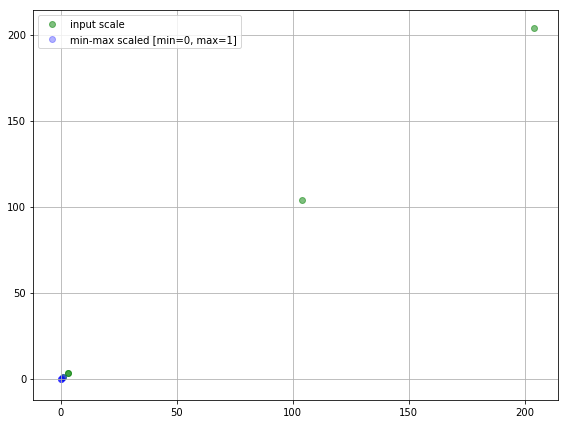

In [5]:
%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(dataGroup2['count'], dataGroup2['count'],
            color='green', label='input scale', alpha=0.5)
        
    plt.scatter(dataNorm['count_n'], dataNorm['count_n'],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)
    
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()

plot()
plt.show()


### 3.1 Vanilla Python

In [6]:
# Standardization

x = dataGroup2['count']
mean = sum(x)/len(x)
std_dev = (1/len(x) * sum([ (x_i - mean)**2 for x_i in x]))**0.5

z_scores = [(x_i - mean)/std_dev for x_i in x]
print(z_scores)
# Min-Max scaling

minmax = [(x_i - min(x)) / (max(x) - min(x)) for x_i in x]
print(minmax)

[-0.74299773604806973, -0.76776432724967203, -0.74299773604806973, 0.50771511963284766, 1.7460446797129638]
[0.009852216748768473, 0.0, 0.009852216748768473, 0.5073891625615764, 1.0]


### 3.2 NumPy

In [7]:
import numpy as np

# Standardization

x_np = np.asarray(x)
z_scores_np = (x_np - x_np.mean()) / x_np.std()
print(z_scores_np)

# Min-Max scaling

np_minmax = (x_np - x_np.min()) / (x_np.max() - x_np.min())
print(np_minmax)

[-0.74299774 -0.76776433 -0.74299774  0.50771512  1.74604468]
[ 0.00985222  0.          0.00985222  0.50738916  1.        ]


### 3.3 Visualization

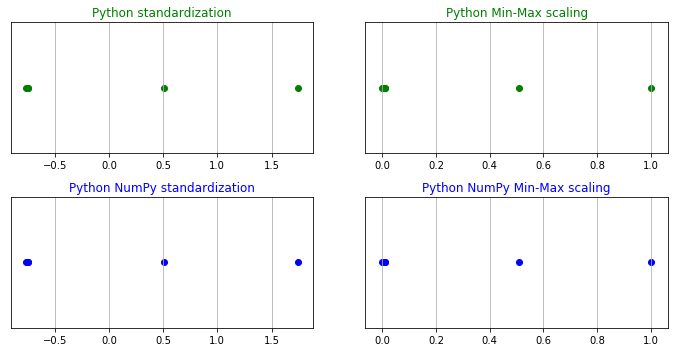

In [8]:
from matplotlib import pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

y_pos = [0 for i in range(len(x))]

ax1.scatter(z_scores, y_pos, color='g')
ax1.set_title('Python standardization', color='g')

ax2.scatter(minmax, y_pos, color='g')
ax2.set_title('Python Min-Max scaling', color='g')

ax3.scatter(z_scores_np, y_pos, color='b')
ax3.set_title('Python NumPy standardization', color='b')

ax4.scatter(np_minmax, y_pos, color='b')
ax4.set_title('Python NumPy Min-Max scaling', color='b')

plt.tight_layout()

for ax in (ax1, ax2, ax3, ax4):
    ax.get_yaxis().set_visible(False)
    ax.grid()

plt.show()


## 4. Isolation Forest

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

dataNorm = dataNorm[['count','count_n']]

# La funcion iloc nos permite seleccionar desde una posición a otra en un array.
dataTrain = dataNorm.iloc[0:5]

iforest = IsolationForest(n_estimators=100, contamination=0.00001, max_samples=5)
iforest.fit(dataTrain)
clf = iforest.fit(dataTrain)
prediction = iforest.predict(dataNorm)

dataGroup2['prediction'] = prediction
dataGroup2[['count','prediction']]

,count,prediction
0,3,1
7,1,1
8,3,1
9,104,1
10,204,-1


#### Example *iloc*:
```python
#return second position (python counts from 0, so 1)
print (df.columns.get_loc('Taste'))
1

df.iloc[0:2, df.columns.get_loc('Taste')] = 'good'
df.iloc[2:6, df.columns.get_loc('Taste')] = 'bad'
print (df)
         Food Taste
0       Apple  good
1      Banana  good
2       Candy   bad
3        Milk   bad
4       Bread   bad
5  Strawberry   bad
```
#### Examples *Isolation Forest*:
- n_estimators : int, optional (default=100)
    
        The number of base estimators in the ensemble.
    
    
- contamination : float in (0., 0.5), optional (default=0.1)
    
        The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function.
        
        
- max_features : int or float, optional (default=1.0)

        The number of features to draw from X to train each base estimator.
            If int, then draw max_features features.
            If float, then draw max_features * X.shape[1] features.



```python

iforest = IsolationForest(n_estimators=100, contamination=0.1)

```

```
 	count 	prediction
76 	34 	    -1
77 	31 	    -1
78 	2 	     1
79 	68 	    -1
80 	98 	    -1
83 	4 	     1
92 	1 	     1
95 	4 	     1
... 1        1
... 1        1
... 1        1

```
```python

iforest = IsolationForest(n_estimators=100, contamination=0.01)

```

```
 	count 	prediction
76 	34 	     1
77 	31 	     1
78 	2 	     1
79 	68 	     1
80 	98 	    -1
83 	4 	     1
92 	1 	     1
95 	4 	     1
... 1        1
... 1        1
... 1        1

```

### 4.1 Plot Isolation Forest

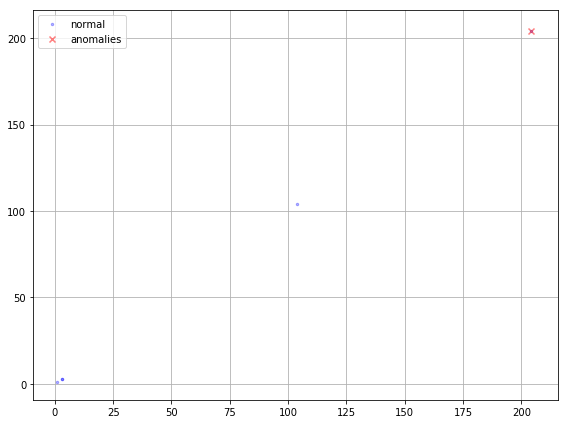

In [10]:
x = dataGroup2[(dataGroup2['prediction'] == -1)]['count'].values

%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(dataGroup2['count'], dataGroup2['count'], s=6, label="normal", alpha=0.3, color="blue")
        
    plt.scatter(x, x, marker="x", color="red", label="anomalies", alpha=0.5)
    
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()

plot()
plt.show()



In [11]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision(X, y, classifier, test_idx=None, resolution=0.02, figsize=(6,6)):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('#cc0000', '#003399', '#00cc00', '#999999', '#66ffff')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # get dimensions
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    xmin = xx1.min()
    xmax = xx1.max()
    ymin = xx2.min()
    ymax = xx2.max()
    
    # create the figure
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # plot the decision surface
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap, zorder=1)
    
    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                   y=X[y == cl, 1],
                   alpha=0.6, 
                   c=cmap(idx),
                   edgecolor='black',
                   marker='o',#markers[idx],
                   s=50,
                   label=cl,
                   zorder=3)

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c='w',
                   alpha=1.0,
                   edgecolor='black',
                   linewidths=1,
                   marker='o',
                   s=150, 
                   label='test set',
                   zorder=2)
        
dataGroup2['idpst_label'], _ = pd.factorize(dataGroup2['ipdst'])
dataGroup2

,ipdst,proto,time,count,prediction,idpst_label
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3,1,0
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1,1,0
8,10.3.20.102,TCP,2017-03-20 17:08:50,3,1,0
9,10.3.20.102,TCP,2017-03-20 17:08:55,104,1,0
10,10.3.20.102,TCP,2017-03-20 17:09:00,204,-1,0


Misclassified samples: 0
Accuracy: 1.00


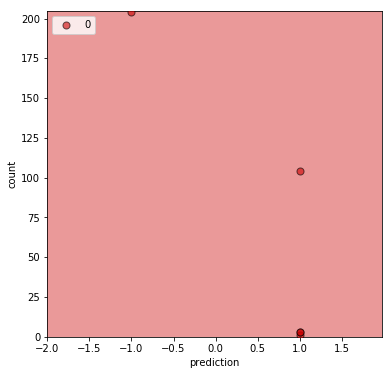

In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pydotplus
from sklearn import tree, metrics, model_selection, preprocessing
from IPython.display import Image, display

dataGroup2['idpst_label'], _ = pd.factorize(dataGroup2['ipdst'])

y = dataGroup2['idpst_label']
X = dataGroup2[['prediction', 'count']]

# split data randomly into 70% training and 30% test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

# train the decision tree
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
dtree.fit(X_train, y_train)

# use the model to make predictions with the test data
y_pred = dtree.predict(X_test)

# how did our model perform?
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))



# visualize the model's decision regions to see how it separates the samples
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision(X=X_combined, y=y_combined, classifier=dtree)
plt.xlabel('prediction')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.show()

# Solo tenemos una IP.

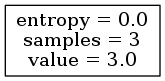

In [13]:
dot_data = tree.export_graphviz(dtree, out_file=None, filled=False, rounded=False,
                                feature_names=['count', 'count'],  
                                class_names=['10.3.20.102'])
                                #class_names=['ip1', 'ip2', 'ip3', ...])
graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

# Solo muestra uno debido a que solo tenemos una IP

El ejemplo con más IPs sería:
![](prediction.png)
![](tree.png)

## 5. Gráficas

In [14]:
import plotly.plotly as py
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
init_notebook_mode(connected=True)

import plotly.offline as offline
import plotly.graph_objs as go
from plotly.graph_objs import *

### 5.1 Sin ordenar Tiempos

In [15]:
dataGroup2

,ipdst,proto,time,count,prediction,idpst_label
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3,1,0
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1,1,0
8,10.3.20.102,TCP,2017-03-20 17:08:50,3,1,0
9,10.3.20.102,TCP,2017-03-20 17:08:55,104,1,0
10,10.3.20.102,TCP,2017-03-20 17:09:00,204,-1,0


In [16]:
#Normal Traffic
nor = dataGroup2[(dataGroup2['prediction'] == 1)]['count']
#Anomalies
ano = dataGroup2[(dataGroup2['prediction'] == -1)]['count']


normal = go.Scatter(
    x = dataGroup2[(dataGroup2['prediction'] == 1)]['time'],
    y = nor,
    mode = "lines+markers",
    name = "Normal Traffic"
)


anomalies = dict(
    x=dataGroup2[(dataGroup2['prediction'] == -1)]['time'],
    y=ano,
    name = "Anomalies",
    mode = 'markers',
    marker=Marker(
            size=7,
            symbol= "circle",
            color='rgb(255, 0, 0)'
        ),
    opacity = 0.8)

data = [normal, anomalies]

layout = dict(
    title='Peticiones totales por tiempo',
    xaxis=dict(
        title = 'Date',
        rangeslider=dict(),
        type='date'
    ),
    yaxis=dict(
        title = 'Nº packets'
    ),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=12,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    ) 
)

fig = dict(data=data, layout=layout)
iplot(fig, filename = "Peticiones totales por tiempo")

### 5.2 Ordenando Tiempos

In [17]:
dataGroup3 = dataGroup2.sort_values(by=['time'])
dataGroup3

,ipdst,proto,time,count,prediction,idpst_label
8,10.3.20.102,TCP,2017-03-20 17:08:50,3,1,0
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3,1,0
9,10.3.20.102,TCP,2017-03-20 17:08:55,104,1,0
10,10.3.20.102,TCP,2017-03-20 17:09:00,204,-1,0
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1,1,0


In [18]:
#Normal Traffic
nor = dataGroup3[(dataGroup3['prediction'] == 1)]['count']
#Anomalies
ano = dataGroup3[(dataGroup3['prediction'] == -1)]['count']


normal = go.Scatter(
    x = dataGroup3[(dataGroup3['prediction'] == 1)]['time'],
    y = nor,
    mode = "lines+markers",
    name = "Normal Traffic"
)


anomalies = dict(
    x=dataGroup3[(dataGroup3['prediction'] == -1)]['time'],
    y=ano,
    name = "Anomalies",
    mode = 'markers',
    marker=Marker(
            size=7,
            symbol= "circle",
            color='rgb(255, 0, 0)'
        ),
    opacity = 0.8)

data = [normal, anomalies]

layout = dict(
    title='Peticiones totales por tiempo',
    xaxis=dict(
        title = 'Date',
        rangeslider=dict(),
        type='date'
    ),
    yaxis=dict(
        title = 'Nº packets'
    ),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=12,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    ) 
)

fig = dict(data=data, layout=layout)
iplot(fig, filename = "Peticiones totales por tiempo")

In [19]:
dataGroup4 = dataGroup2.groupby(['time']).sum().reset_index().dropna()
dataGroup4

,time,count,prediction,idpst_label
0,2017-03-20 17:08:50,3,1,0
1,2017-03-20 17:08:55,107,2,0
2,2017-03-20 17:09:00,204,-1,0
3,2017-03-20 17:09:30,1,1,0


In [20]:
#Normal Traffic
nor = dataGroup4[(dataGroup4['prediction'] == 1)]['count']
#Anomalies
ano = dataGroup4[(dataGroup4['prediction'] == -1)]['count']


normal = go.Scatter(
    x = dataGroup4[(dataGroup4['prediction'] == 1)]['time'],
    y = nor,
    mode = "lines+markers",
    name = "Normal Traffic"
)


anomalies = dict(
    x=dataGroup4[(dataGroup4['prediction'] == -1)]['time'],
    y=ano,
    name = "Anomalies",
    mode = 'markers',
    marker=Marker(
            size=7,
            symbol= "circle",
            color='rgb(255, 0, 0)'
        ),
    opacity = 0.8)

data = [normal, anomalies]

layout = dict(
    title='Peticiones totales por tiempo',
    xaxis=dict(
        title = 'Date',
        rangeslider=dict(),
        type='date'
    ),
    yaxis=dict(
        title = 'Nº packets'
    ),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=12,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    ) 
)

fig = dict(data=data, layout=layout)
iplot(fig, filename = "Peticiones totales por tiempo")

## 6. Mapa anomalías

In [21]:
import re
import json
from urllib.request import urlopen
import plotly.plotly as py
from plotly.graph_objs import *
import numpy

mapbox_access_token = 'pk.eyJ1IjoiYWxleGZyYW5jb3ciLCJhIjoiY2pnbHlncDF5MHU4OTJ3cGhpNjE1eTV6ZCJ9.9RoVOSpRXa2JE9j_qnELdw'

# Como el dataframe a analizar no tiene ninguna IP pública se hará uso de 4 IPs públicas elegidas manualmente.
#ips = dataGroup2[(dataGroup2['prediction'] == -1)]['ipdst'].values
ips = ['157.240.21.35','23.253.135.79','104.244.42.193', '213.60.47.49']


outputLat = []
outputLon = []
for ip in ips:
    #url = 'http://ip-api.com/json/'+ip
    url = 'http://freegeoip.net/json/'+ip
    response = urlopen(url)
    data = json.load(response)
    #print(ip+": ")

    try:
        data['message']
        print("IP Privada")

    except (KeyError, TypeError) as e:
        lat = str(data['latitude'])
        latList = str(data['latitude']).split()
        lon = str(data['longitude'])
        lonList = str(data['longitude']).split()
        #print(lat, lon)
        outputLat.append(lat)
        outputLon.append(lon)
        
#debug lat and lon array        
# print(outputLat)
# print(outputLon)
        
data = Data([
    Scattermapbox(
        lat=outputLat,
        lon=outputLon,
        mode='markers',
        marker=Marker(
            size=14,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=ips,
    ), 
])

#debug data
# print(data)

layout = Layout(
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=lat,
            lon=lon
        ),
        pitch=0,
        style='light',
        zoom=1
    ),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=12,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    ), 
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='Montreal Mapbox')


## 7. Visualizing a Single Decision Tree
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [22]:
dataGroup2

,ipdst,proto,time,count,prediction,idpst_label
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3,1,0
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1,1,0
8,10.3.20.102,TCP,2017-03-20 17:08:50,3,1,0
9,10.3.20.102,TCP,2017-03-20 17:08:55,104,1,0
10,10.3.20.102,TCP,2017-03-20 17:09:00,204,-1,0


![](tree.png)

```python
dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=feature_list,
                                    class_names=feature_list,
                                    filled=True, rounded=True,
                                    special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("tree-vis.pdf")
joblib.dump(clf, 'CART.pkl') 
```

# 8. Detector de IP pública o privada

URL: https://chrisalbon.com/python/data_wrangling/pandas_create_column_with_loop/

## Predicciones

In [25]:
ips = dataGroup3[(dataGroup3['prediction'] == -1)]['ipdst']

def is_public_ip(ip):
    ip = list(map(int, ip.strip().split('.')[:2]))
    if ip[0] == 10: return False
    if ip[0] == 172 and ip[1] in range(16, 32): return False
    if ip[0] == 192 and ip[1] == 168: return False
    return True

for ip in ips:
    if is_public_ip(ip):
        print(dataGroup3[(dataGroup3['prediction'] == -1)]['ipdst'] + ' publica')
    else:
        print(dataGroup3[(dataGroup3['prediction'] == -1)]['ipdst'] + ' privada')

10    10.3.20.102 privada
Name: ipdst, dtype: object


In [26]:
ips = dataGroup3[(dataGroup3['prediction'] == -1)]['ipdst']
dataGroup5 = dataGroup3[(dataGroup3['prediction'] == -1)]

def is_public_ip(ip):
    ip = list(map(int, ip.strip().split('.')[:2]))
    if ip[0] == 10: return False
    if ip[0] == 172 and ip[1] in range(16, 32): return False
    if ip[0] == 192 and ip[1] == 168: return False
    return True

tipo = []
for ip in ips:
    if is_public_ip(ip):
        tipo.append('publica')
    else:
        tipo.append('privada')
        
dataGroup5['tipo'] = tipo
dataGroup5

/home/alexfrancow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,ipdst,proto,time,count,prediction,idpst_label,tipo
10,10.3.20.102,TCP,2017-03-20 17:09:00,204,-1,0,privada


# 9. Detector pais

Todas las IPS son privadas por lo tanto no va a haber nada.

In [27]:
dataGroup5[(dataGroup5['tipo'] == 'publica')]['ipdst']

Series([], Name: ipdst, dtype: object)

In [28]:
ips = dataGroup5[(dataGroup5['tipo'] == 'publica')]['ipdst']

for ip in ips:
    #url = 'http://ip-api.com/json/'+ip
    url = 'http://freegeoip.net/json/'+ip
    response = urlopen(url)
    data = json.load(response)
    print(ip+": ")
    data['country_name']
    country = str(data['country_name'])
    print (country)

Ejemplo si hubiera una IP publica:
```
92.53.104.78: 
Russia
```